# Setup

In [1]:
%%capture
import scanpy as sc
import scvi
import os
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scrublet as scr

In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
sns.set_context("paper")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/mnt/f/mTEC-eTAC-atlases/mTEC-analysis'

## Set data paths

### demeter

In [4]:
# rawDataPath = "/mnt/iacchus/joe/raw_data/"
# processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Import data

## Michelson 2022

In [6]:
adataMichelson = sc.read_10x_mtx(f"{rawDataPath}/Thymus/Michelson_2022/scRNAseq/adult_perinate_gex/", prefix="GSM5831744_adult_perinate_gex_", cache=True)
metadata = pd.read_csv(f"{rawDataPath}/Thymus/Michelson_2022/scRNAseq/GSM5831744_adult_perinate_metadata.txt", index_col=0, sep=" ")
adataMichelson = adataMichelson[adataMichelson.obs.index.isin(metadata.index)]
adataMichelson.layers["counts"] = adataMichelson.X.copy()
adataMichelson.obs["batch"] = "WT_Mathis"
adataMichelson.obs["hash"] = metadata.hash_ident
adataMichelson = adataMichelson[adataMichelson.obs.hash.str.startswith("adult")]
adataMichelson.obs["cell_type"] = "other_dataset"
adataMichelson.obs["genotype"] = "WT"
adataMichelson.obs["dataset"] = "Mathis"

/tmp/ipykernel_1526/927008742.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adataMichelson.obs["cell_type"] = "other_dataset"


In [7]:
adataMichelson

AnnData object with n_obs × n_vars = 7153 × 55487
    obs: 'batch', 'hash', 'cell_type', 'genotype', 'dataset'
    var: 'gene_ids', 'feature_types'
    layers: 'counts'

## Miller 2023

In [8]:
adataMiller = sc.read(f"{processedDataPath}M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
adataMiller.X = adataMiller.layers["counts"].copy()
adataMiller.obs["dataset"] = "Miller"

# Combine datasets

In [9]:
adata = ad.concat([adataMichelson, adataMiller], index_unique="-")

/opt/conda/envs/single-cell-analysis/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


# Preprocessing

In [10]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

## QC plotting

### QC filter

In [11]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True, save_path=None):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    ax =sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    ax.set(yscale="log")
    ax.set(xscale="log")
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

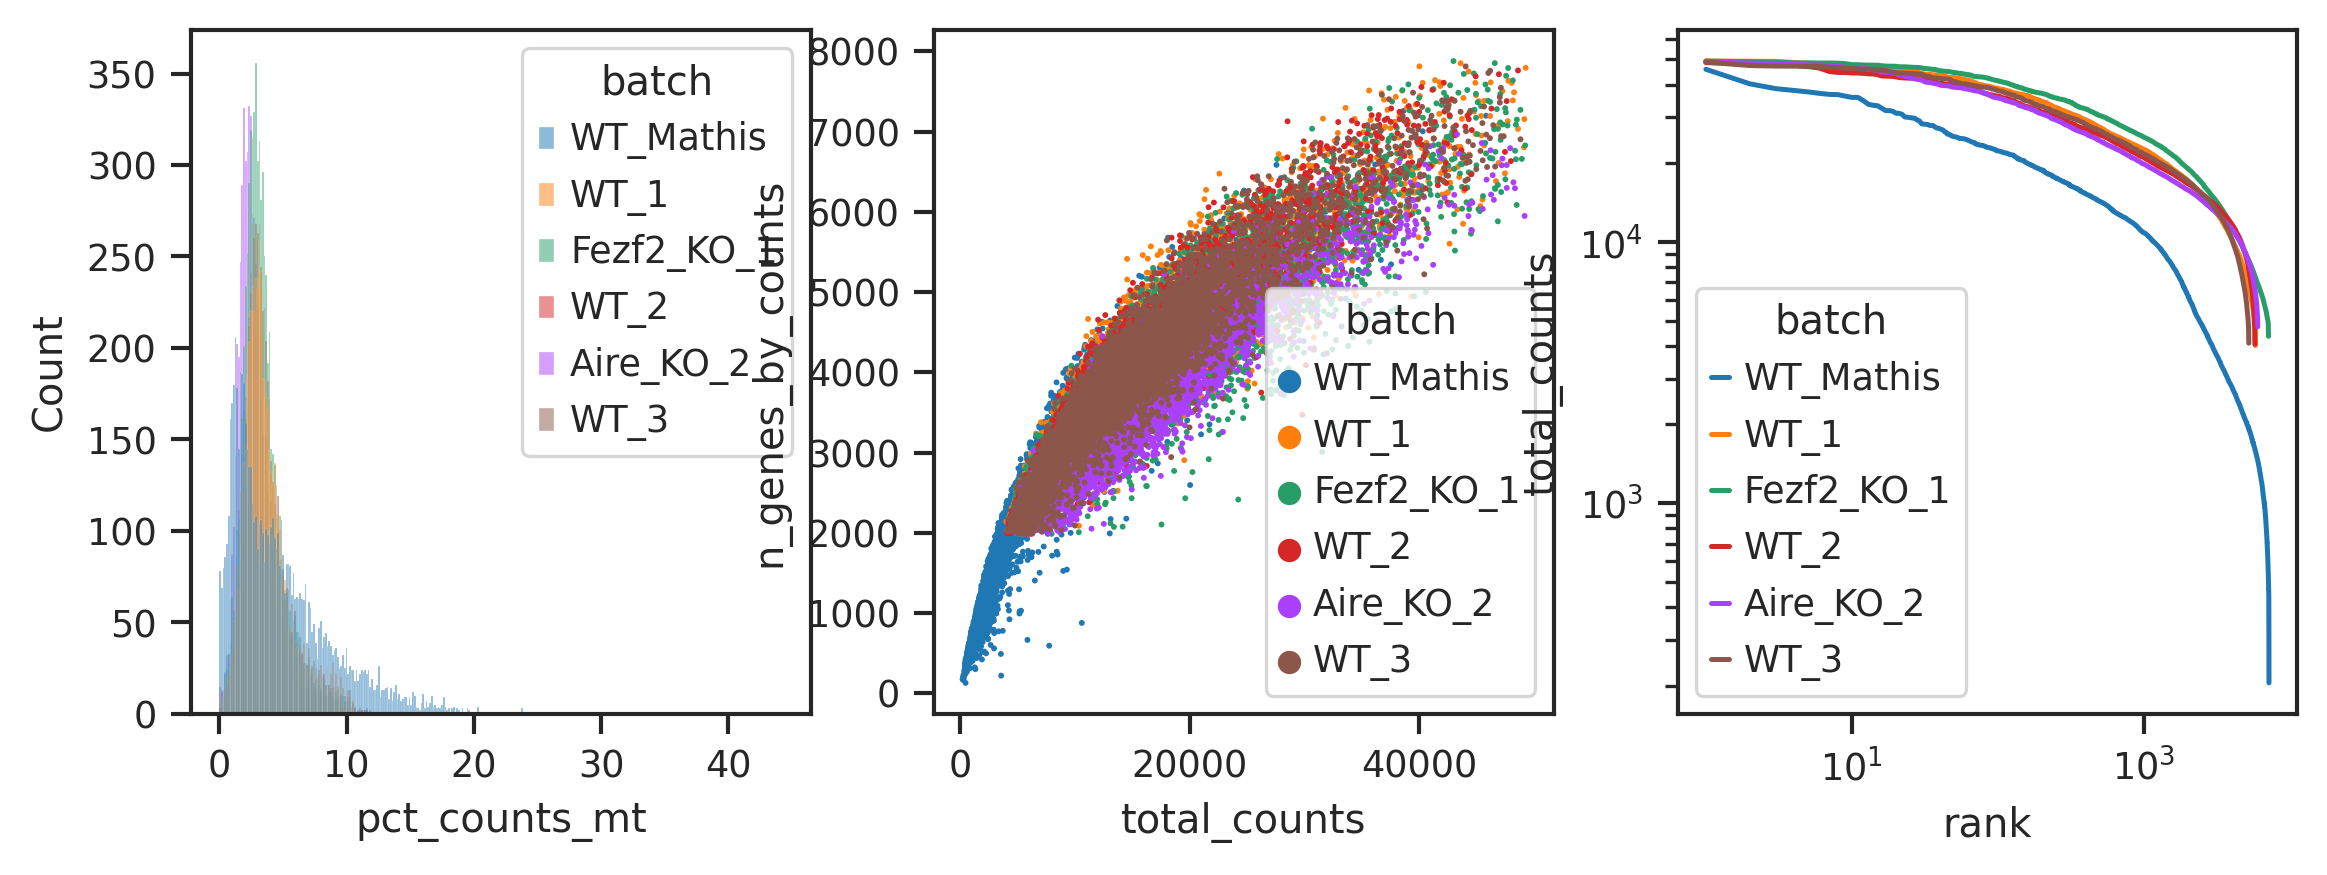

In [12]:
# Check QC thresholds before filtering
qc_plot(adata, show_thresh=False,)

## Normalize data (scanpy)

In [13]:
# Scanpy preprocessing pipeline
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

In [14]:
adata

AnnData object with n_obs × n_vars = 36969 × 27805
    obs: 'batch', 'cell_type', 'genotype', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

# scVI training

In [15]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
)
model = scvi.model.SCVI(adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [16]:
# Train scVI model
model.train()

Epoch 6/216:   2%|▏         | 5/216 [01:09<48:09, 13.70s/it, loss=1.03e+04, v_num=1]

/opt/conda/envs/single-cell-analysis/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [ ]:
# Checl save paths
if not os.path.isdir(f"{processedDataPath}/mTEC_analysis/scVI_models"):
    os.makedirs(f"{processedDataPath}/mTEC_analysis/scVI_models")
    
if not os.path.isdir(f"{processedDataPath}/mTEC_analysis/h5ad_files"):
    os.makedirs(f"{processedDataPath}/mTEC_analysis/h5ad_files")
    
if os.path.isdir(f"{processedDataPath}/mTEC_analysis/scVI_models/merged_thymus_atlas"):
    shutil.rmtree(f"{processedDataPath}/mTEC_analysis/scVI_models/merged_thymus_atlas")
    
# save the scVI model and adata object before further processing because training is non-deterministic
model.save(f"{processedDataPath}/mTEC_analysis/scVI_models/merged_thymus_atlas")
adata.write(f"{processedDataPath}/mTEC_analysis/h5ad_files/merged_thymus_atlas.h5ad")

# Dimensionality reduction

In [7]:
adata = sc.read(f"{processedDataPath}/mTEC_analysis/h5ad_files/merged_thymus_atlas.h5ad")

In [42]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.25,)

# Clustering

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


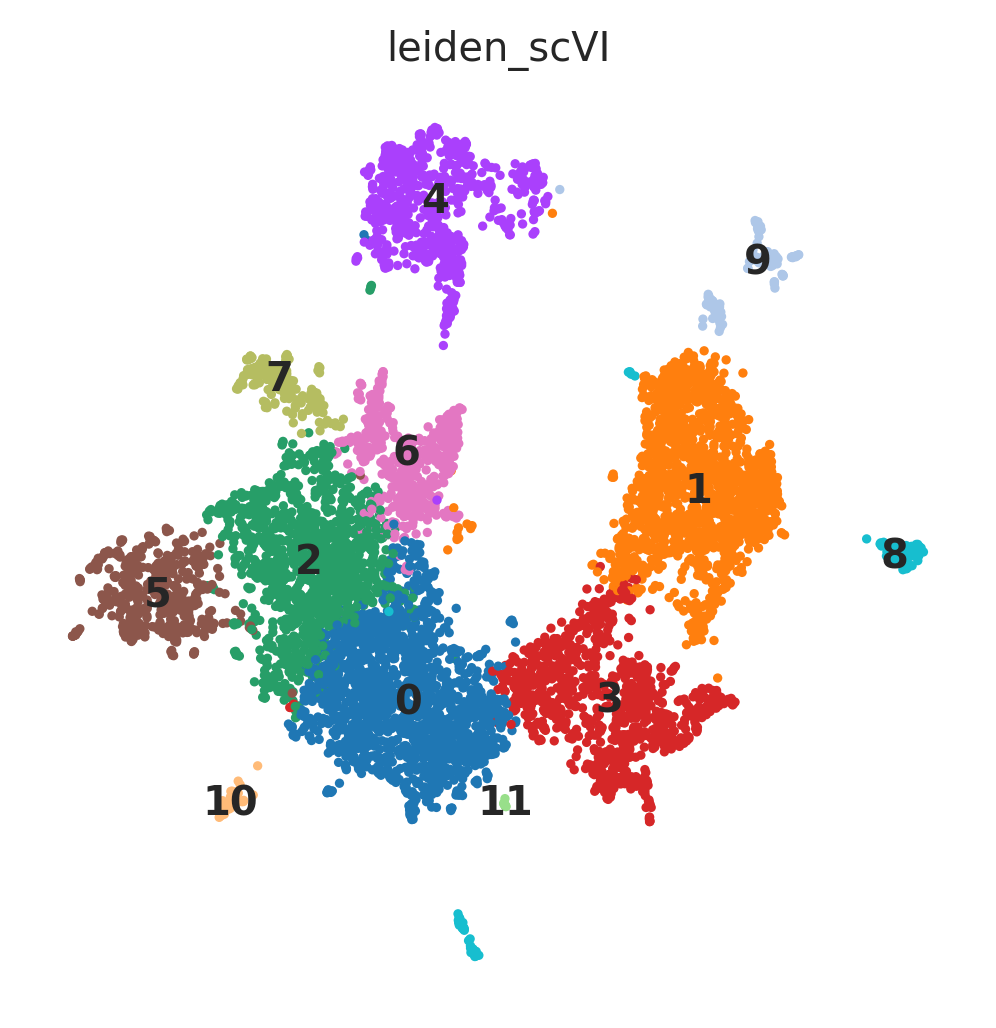

In [52]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.4)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
    s=20,
)

In [55]:
# Recompute umap
sc.tl.umap(adata, min_dist=0.25,)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


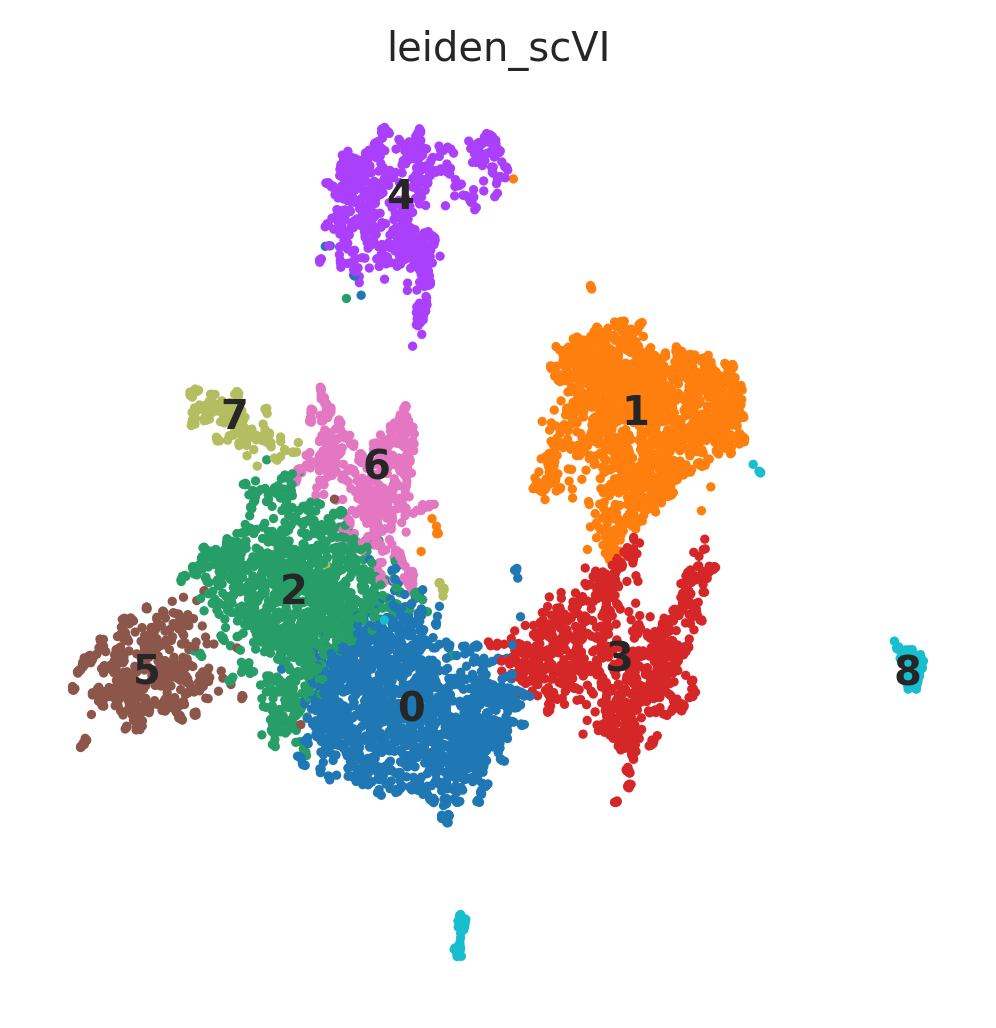

In [56]:
# Recluster
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.4)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
    s=20,
)

# Cell Type Assignment

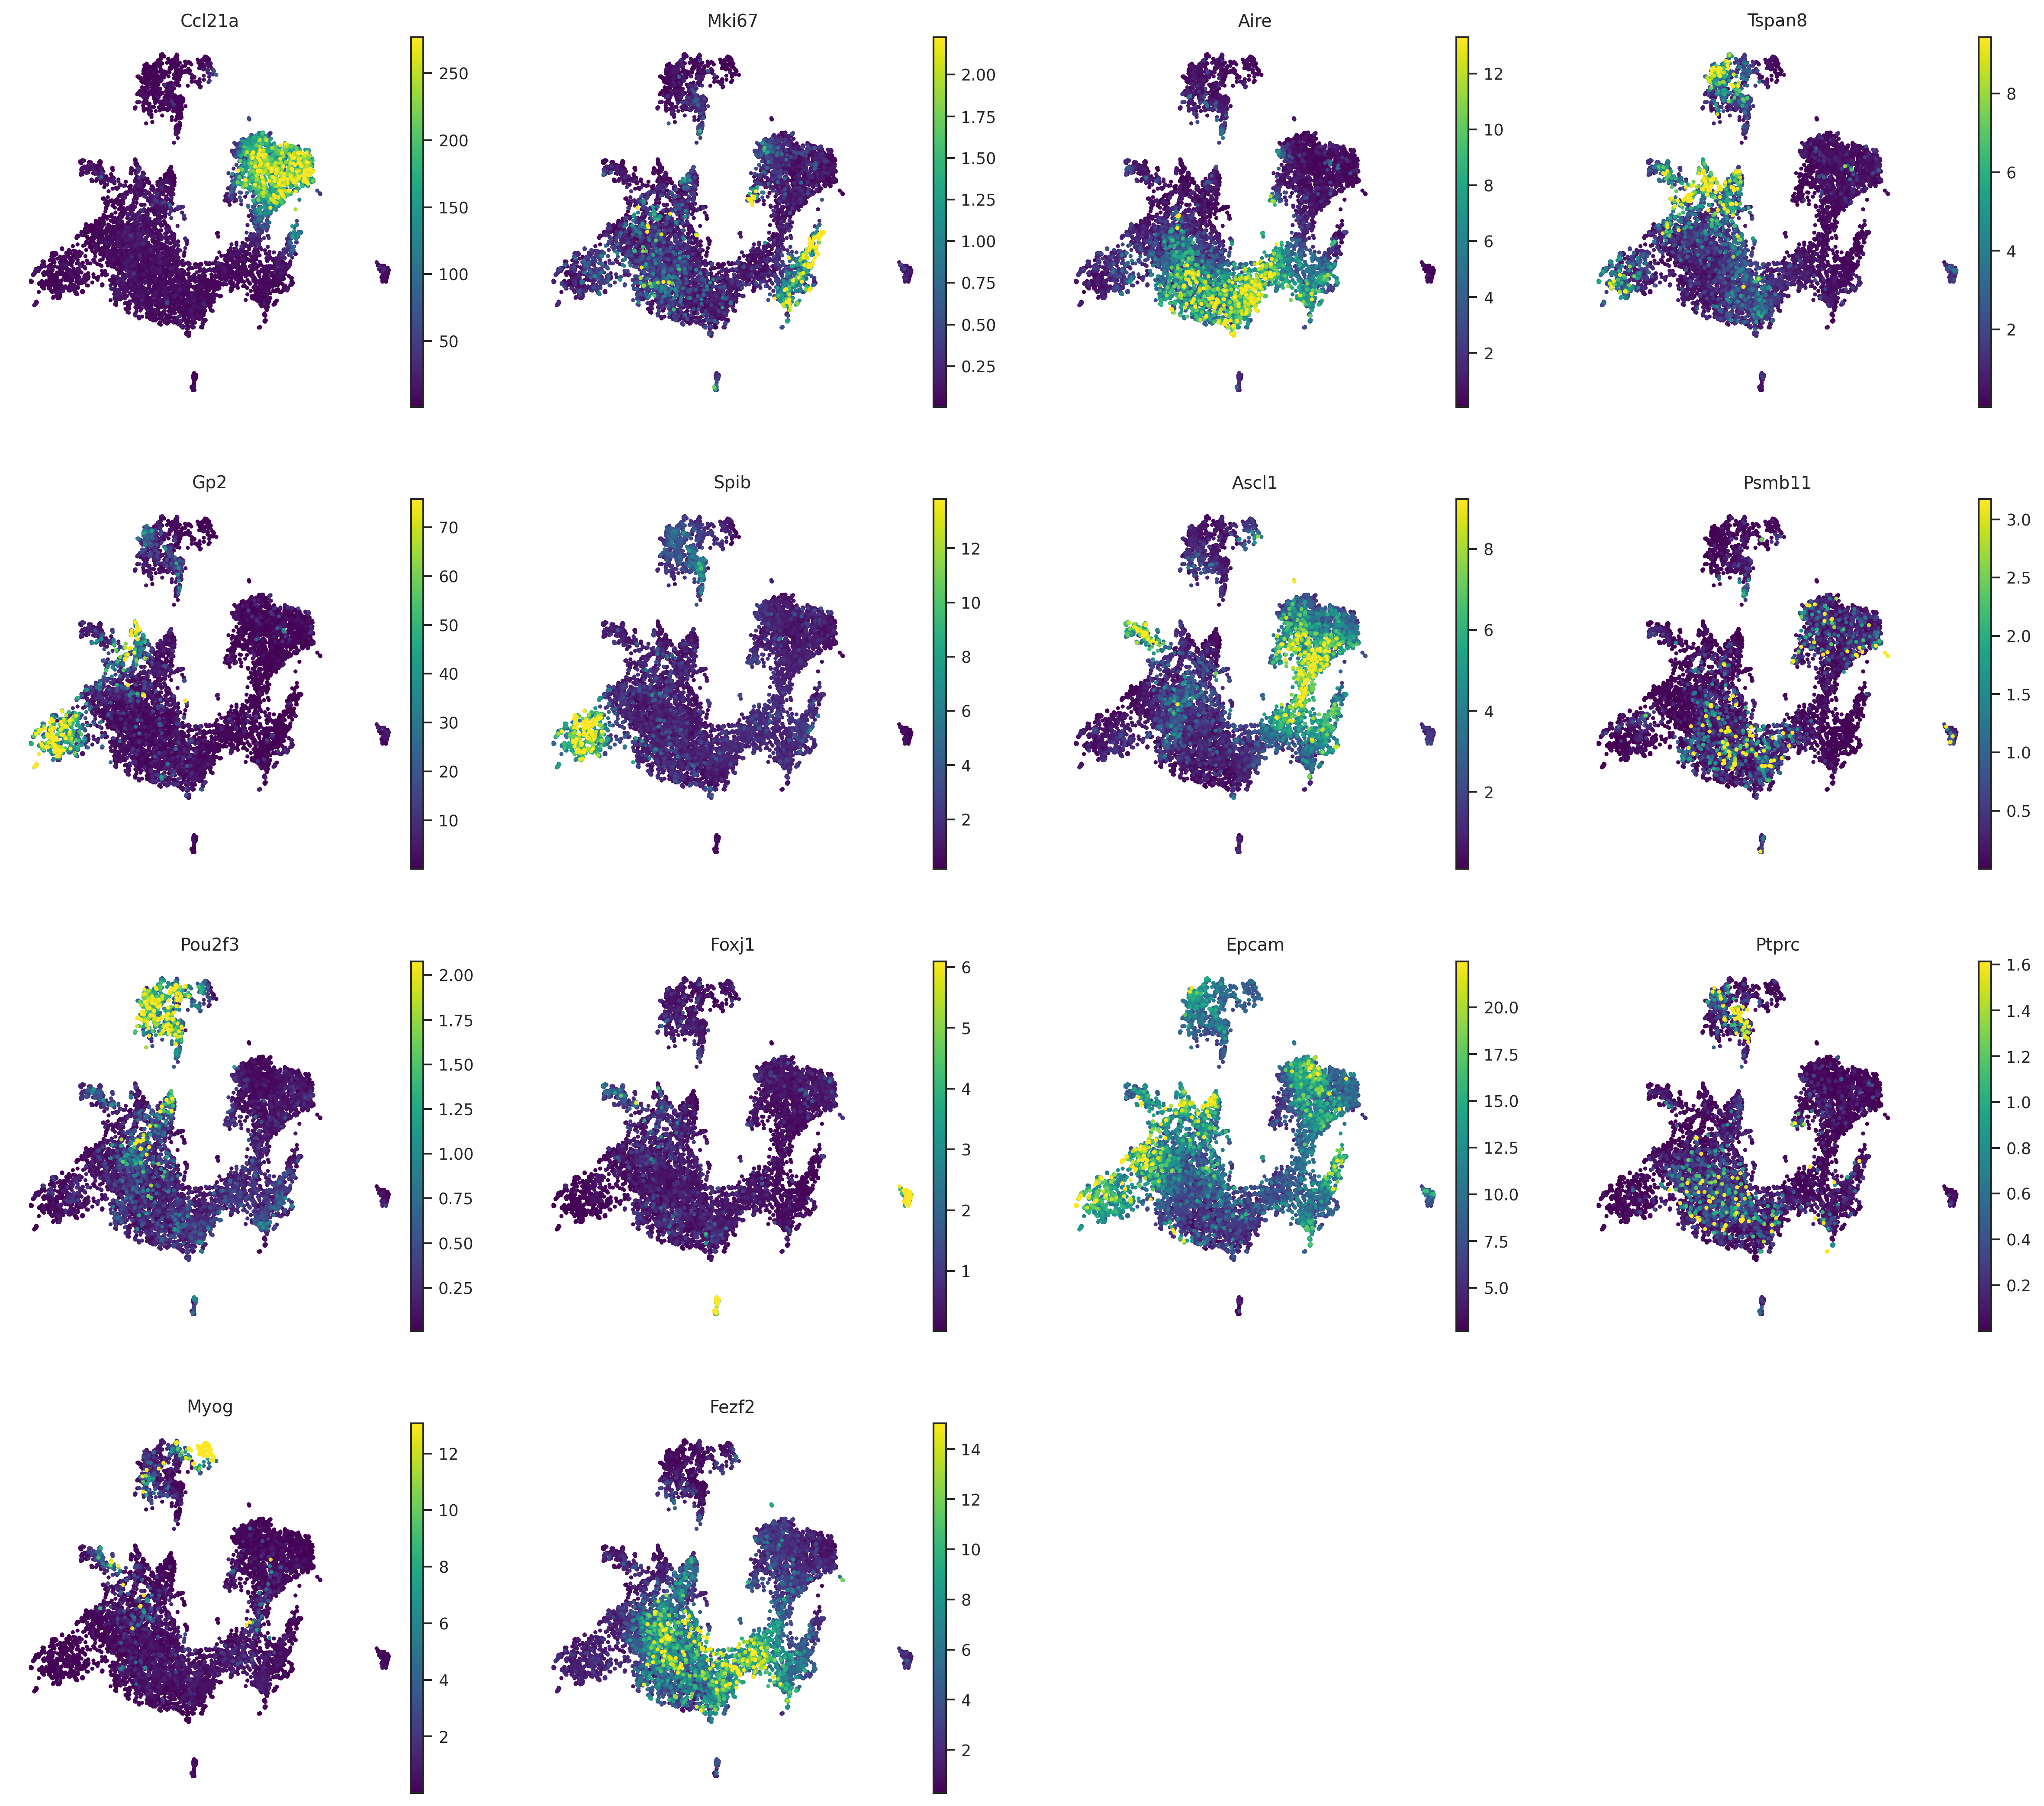

In [57]:
# Rename leiden clusters with corresponding cell types
cellTypes = {

}
adata.obs["cell_type_aggregated"] = adata.obs.leiden_scVI.replace(cellTypes)

# Plot key marker genes
geneList = ["Ccl21a", "Mki67", "Aire", "Tspan8", "Gp2", "Spib", "Ascl1", "Psmb11", "Pou2f3", "Foxj1", "Epcam", "Ptprc", "Myog", "Fezf2"]
vmin=[]
vmax=[]
for gene in geneList:
    vmin.append(np.quantile(adata[:, gene].layers["scVI_normalized"], 0.01))
    vmax.append(np.quantile(adata[:, gene].layers["scVI_normalized"], 0.99))
sc.pl.umap(
    adata,
    color=geneList,
    layer="scVI_normalized",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    s=20,
)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


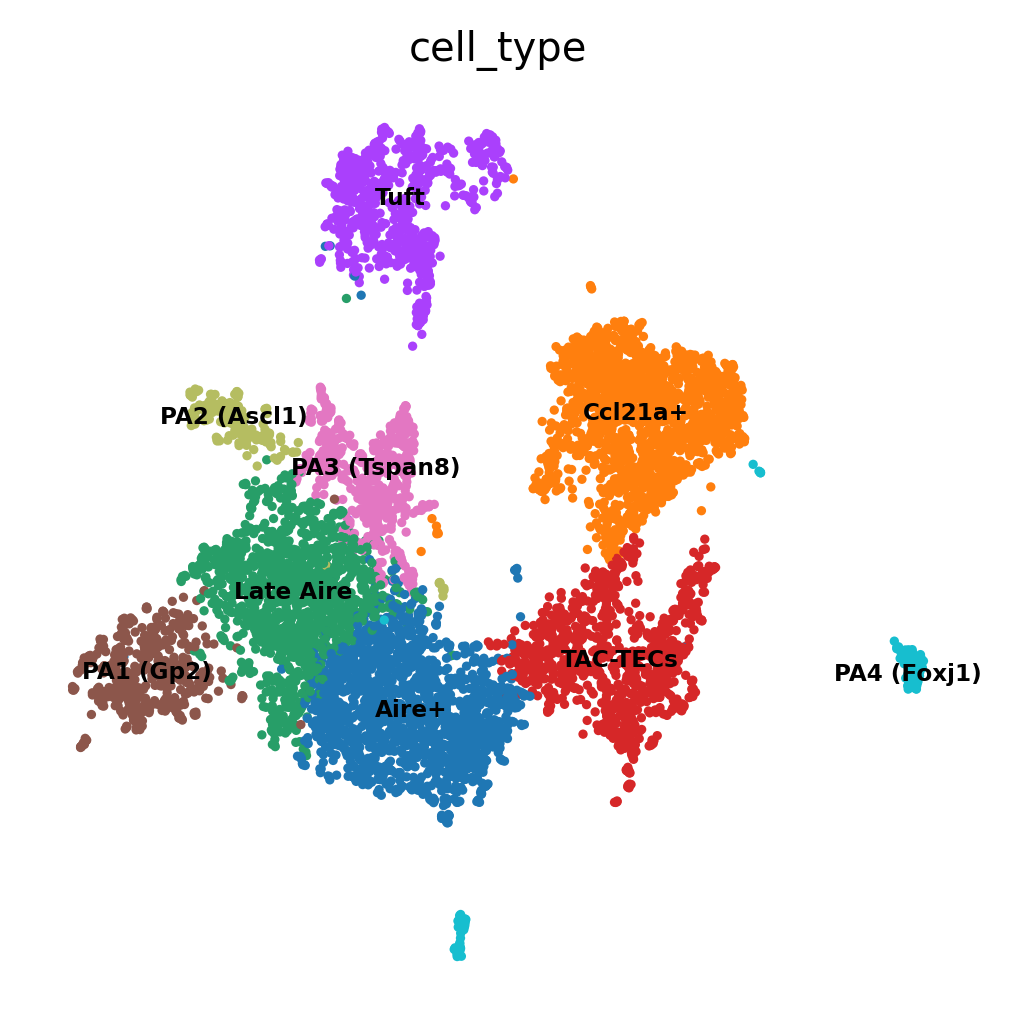

In [8]:
sc.pl.umap(
    adata,
    color=["cell_type", "cell_type_aggregated"],
    legend_loc="on data",
    legend_fontsize="xx-small",
    s=20,
)

# Save Anndata

In [113]:
adata.write(f"{processedDataPath}/mTEC_analysis/h5ad_files/merged_thymus_atlas.h5ad")

In [ ]:
data = pd.DataFrame(adata.layers["scVI_normalized"], index=adata.obs, columns=adata.var_names)
data["genotype"] = adata.obs.genoytpe
data["x"] = [i[0] for i in adata.obsm["X_umap"]]
data["y"] = [i[1] for i in adata.obsm["X_umap"]]
data["cell_type_Miller"] = adata.obs.cell_type
data["cell_type_aggregated"] = adata.obs.cell_type_aggregated
data["dataset"] = adata.obs.dataset

In [ ]:
data.to_csv("thymus_combined_Jan_2023.csv")
data = pd.read_csv("thymus_combined_Jan_2023.csv", index_col=0)
data.to_hdf("thymus_combined_Jan_2023.hdf5")